## algorithm thresholding


In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import pygwalker as pyg
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.GazeCollision import GazeCollision
from src.d03_processing.fixations.VR_IDT import VR_IDT
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d03_processing.fixations.I_HMM import I_HMM
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.fixations.FixAlgos import *
from src.d03_processing.feature_calculate.viewing_compare_calcs import ea_td

In [2]:
# plot functions
def on_off_plot(tps, cols, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    # multipliers = list(range(1, len(cols) + 1))
    adders = [float(i) * 1.5 for i in range(len(cols))]
    t = tps.eye_timestamp_ms.to_numpy() 
    print(tps.viewing_id[0])
    t = t - t[0]
    colors = itertools.cycle(["r", "b", "g", "c", "m"])
    
    for i in range(len(cols)):
        y = np.array(tps[cols[i]].to_numpy(), dtype=float)
        y += float(adders[i])
        ax.plot(t, y, color=next(colors))
    
    ax.set_yticks(adders, cols)

In [3]:
# get viewings
n = 20
all_trials = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_real_trials.csv")
n_trials = len(all_trials)
print(n_trials)
r_inds = np.random.randint(0, n_trials, n)
rand_trials = list(all_trials.trial_id.to_numpy()[r_inds])

# temp while bug fixed
for t in rand_trials:
    if '21r2' in t:
        rand_trials.remove(t)
        
viewings = []
for t in rand_trials:
    viewings.append(f"{t}_enc")
    viewings.append(f"{t}_ret")

# viewings = ['alloeye_3r2_13_ret']
timepoints = fetch_timepoints("all", viewing_id=viewings)
print(timepoints.shape)

p_tps = []
n_viewings = len(viewings)
# preprocess
for i in range(n_viewings):
    # ind = random.randint(0, len(viewings)-1)
    viewing = viewings[i]
    # viewing = "alloeye_52r2_17_ret"

    # print(viewing)
    tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
    if tps is None or len(tps) < 2:
        p_tps.append(None)
        continue
    # print(viewings[i])
    # print(tps.shape)
    s_tps = SignalProcessor.sandwiched_gp_filter(tps.copy(deep=True))
    b_tps = BlinkProcessor(s_tps.copy(deep=True), max_blink_duration=1000, d_impute_threshold=0.16, impute_buffer_duration=8).timepoints
    if b_tps is None:
        print(f"{viewing} all blinks?")
        p_tps.append(None)
        continue
    f_tps = SignalProcessor.filter_timepoints(b_tps.copy(deep=True))
    p_tps.append(f_tps)

3977
executing query
SELECT * FROM "alloeye_timepoint_viewing" WHERE retrieval_epoch in ('na', 'view') and viewing_id in ('alloeye_92r1_5_enc', 'alloeye_92r1_5_ret', 'alloeye_40r3_12_enc', 'alloeye_40r3_12_ret', 'alloeye_46r2_2_enc', 'alloeye_46r2_2_ret', 'alloeye_37r1_16_enc', 'alloeye_37r1_16_ret', 'alloeye_55r3_14_enc', 'alloeye_55r3_14_ret', 'alloeye_58r2_3_enc', 'alloeye_58r2_3_ret', 'alloeye_73r2_5_enc', 'alloeye_73r2_5_ret', 'alloeye_92r3_12_enc', 'alloeye_92r3_12_ret', 'alloeye_5r1_13_enc', 'alloeye_5r1_13_ret', 'alloeye_55r1_6_enc', 'alloeye_55r1_6_ret', 'alloeye_65r2_3_enc', 'alloeye_65r2_3_ret', 'alloeye_76r1_7_enc', 'alloeye_76r1_7_ret', 'alloeye_46r1_2_enc', 'alloeye_46r1_2_ret', 'alloeye_91r3_14_enc', 'alloeye_91r3_14_ret', 'alloeye_6r1_4_enc', 'alloeye_6r1_4_ret', 'alloeye_75r1_11_enc', 'alloeye_75r1_11_ret', 'alloeye_16r3_14_enc', 'alloeye_16r3_14_ret', 'alloeye_25r1_12_enc', 'alloeye_25r1_12_ret', 'alloeye_4r3_8_enc', 'alloeye_4r3_8_ret') 
dataframe returned in 0.99897

In [4]:
# fixations

v_algos = {'ivdt': I_VDT,
         'gc': GazeCollision,
        }
d_algos = {'ivdt': I_VDT,
           'idt': VR_IDT,
          }
# DO SOMETHING WITH I_HMM

algos = {**v_algos, **d_algos}
v_thresholds = [30, 40, 50, 60, 70]   # degrees per second
d_thresholds = [1.0, 2.0, 3.0, 4.0, 5.0]   # degrees
algo_names = {}
v_fix_dfs = {}
d_fix_dfs = {}

for name in v_algos.keys():
    for v in v_thresholds:
        v_fix_dfs.update({f"{name}_{v}": []})
for name in d_algos.keys():
    for d in d_thresholds:
        d_fix_dfs.update({f"{name}_{d}": []})    

fix_tps = []
for i in range(len(p_tps)):
    tps = p_tps[i]
    if tps is None:
        fix_tps.append(None)
        for name, _class in v_algos.items():
            for v in v_thresholds:
                v_fix_dfs[f"{name}_{v}"].append(None)
        for name, _class in d_algos.items():
            for d in d_thresholds:
                d_fix_dfs[f"{name}_{d}"].append(None)
        continue
        
    tps = BlinkProcessor.remove_missing(tps.copy(deep=True))
    
    for name, _class in algos.items():
        if name in v_algos.keys():
            for v in v_thresholds:
                instance = _class(tps, angular_v_threshold=v)
                algo_names.update({name: instance.method_name})
                tps[f'{name}_v{v}_fixation'] = instance.timepoints.fixation
                v_fix_dfs[f"{name}_{v}"].append(instance.fix_df)
        if name in d_algos.keys():
            for d in d_thresholds:
                # print(_class)
                instance = _class(tps, max_angle=d)
                algo_names.update({name: instance.method_name})
                tps[f'{name}_d{d}_fixation'] = instance.timepoints.fixation
                d_fix_dfs[f"{name}_{d}"].append(instance.fix_df)
    
    fix_tps.append(tps.copy(deep=True))

    

In [5]:
fix_tps[0].columns

Index(['timepoint_id', 'trial_or_all', 'ppt_id', 'study_id', 'block_id',
       'trial_id', 'viewing_id', 'retrieval_epoch', 'eye_timestamp_ms',
       'unity_timestamp', 'eye_frame_number', 'unity_frame_number', 'fps',
       'gaze_object', 'object_position_x', 'object_position_y',
       'object_position_z', 'gaze_collision_x', 'gaze_collision_y',
       'gaze_collision_z', 'left_pupil_diameter', 'right_pupil_diameter',
       'left_eye_openness', 'right_eye_openness', 'camera_x', 'camera_y',
       'camera_z', 'cam_rotation_x', 'cam_rotation_y', 'cam_rotation_z',
       'right_controller_x', 'right_controller_y', 'right_controller_z',
       'right_cntrllr_rot_x', 'right_cntrllr_rot_y', 'right_cntrllr_rot_z',
       'left_controller_x', 'left_controller_y', 'left_controller_z',
       'left_cntrllr_rot_x', 'left_cntrllr_rot_y', 'left_cntrllr_rot_z',
       'left_gaze_origin_x', 'left_gaze_origin_y', 'left_gaze_origin_z',
       'right_gaze_origin_x', 'right_gaze_origin_y', 'right_ga

C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


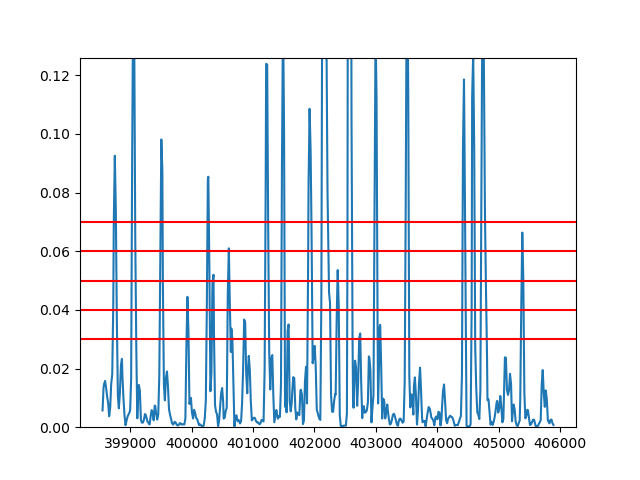

ivdt
ivdt v = 30
alloeye_92r1_5_ret


C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


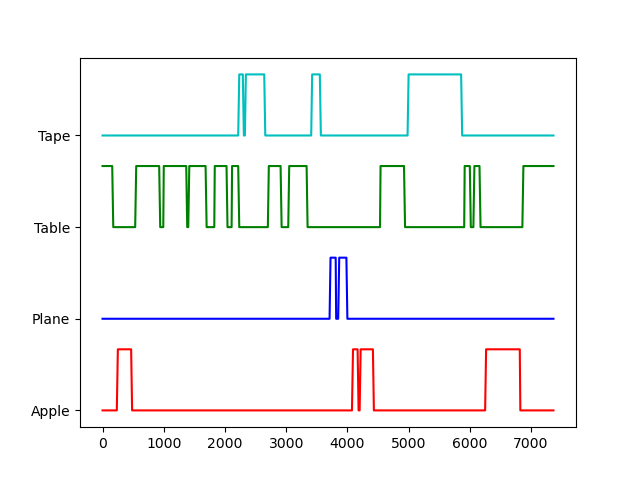

ivdt v = 40
alloeye_92r1_5_ret


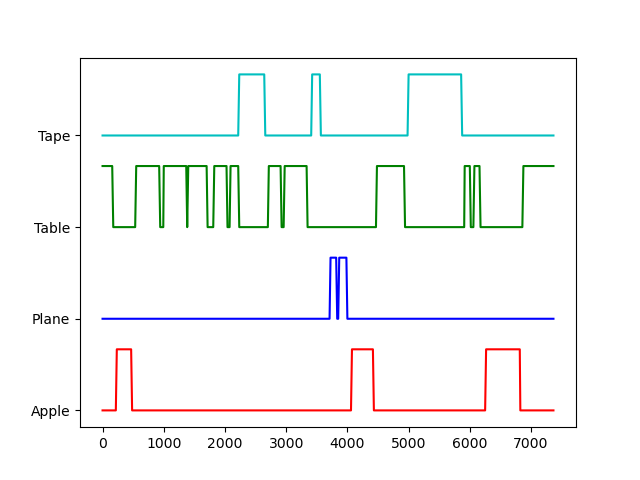

ivdt v = 50
alloeye_92r1_5_ret


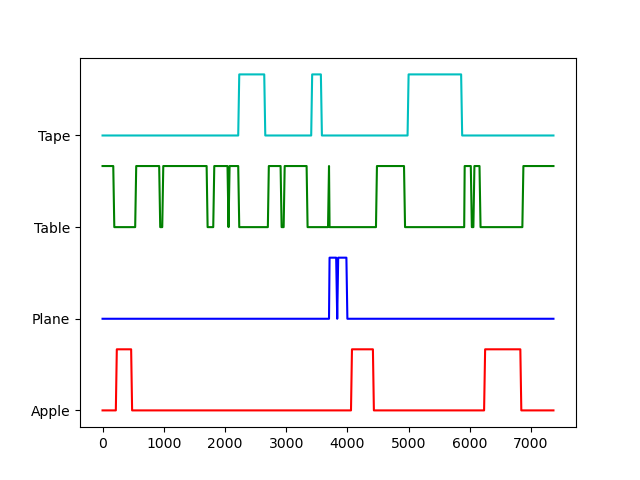

ivdt v = 60
alloeye_92r1_5_ret


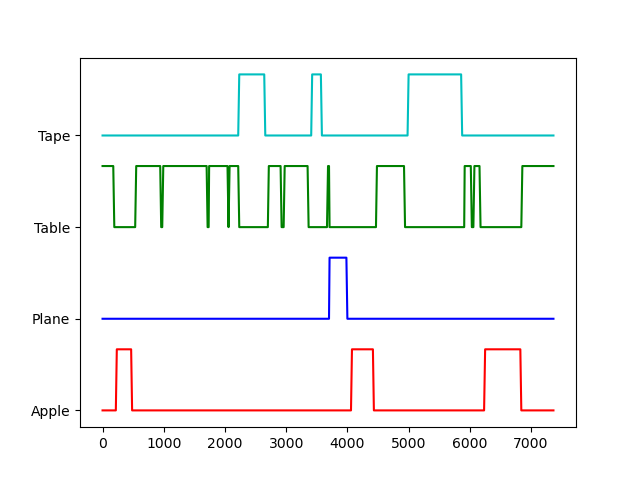

ivdt v = 70
alloeye_92r1_5_ret


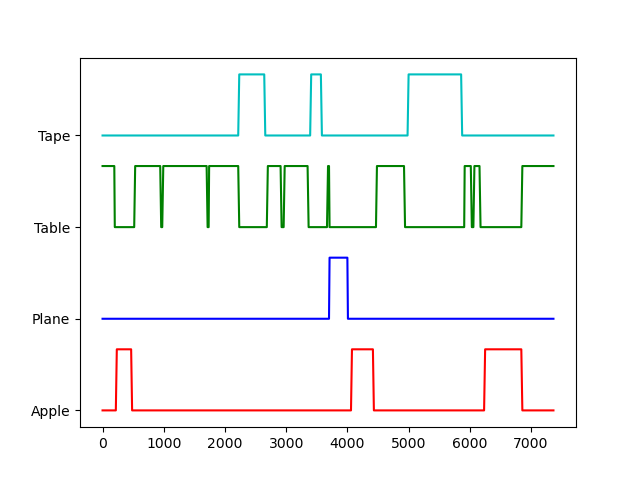

gc
gc v = 30
alloeye_92r1_5_ret


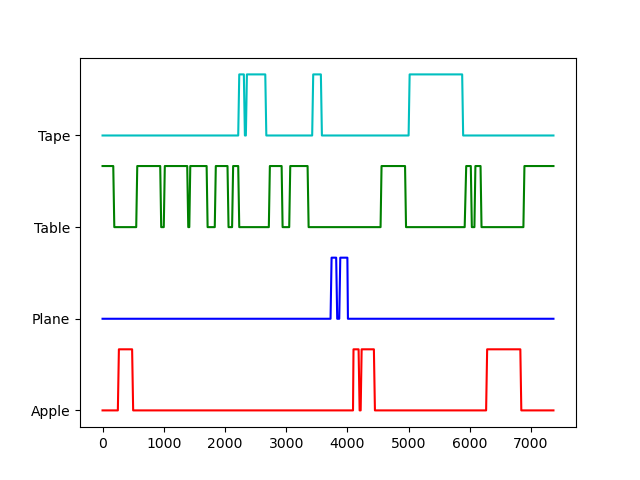

gc v = 40
alloeye_92r1_5_ret


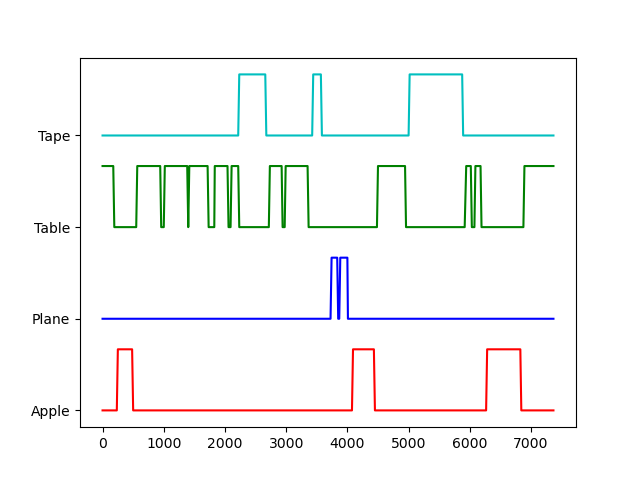

gc v = 50
alloeye_92r1_5_ret


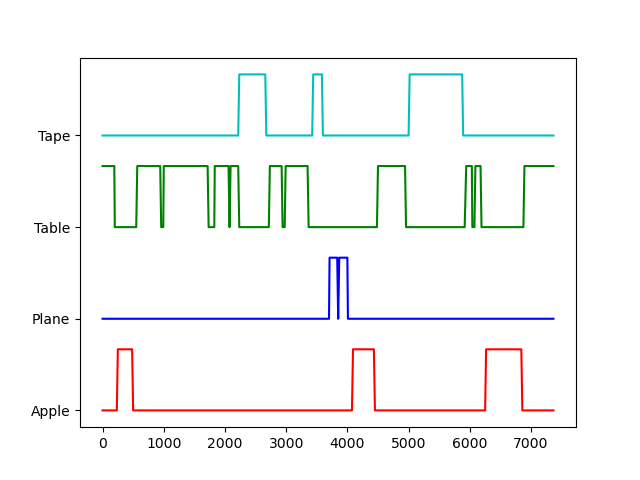

gc v = 60
alloeye_92r1_5_ret


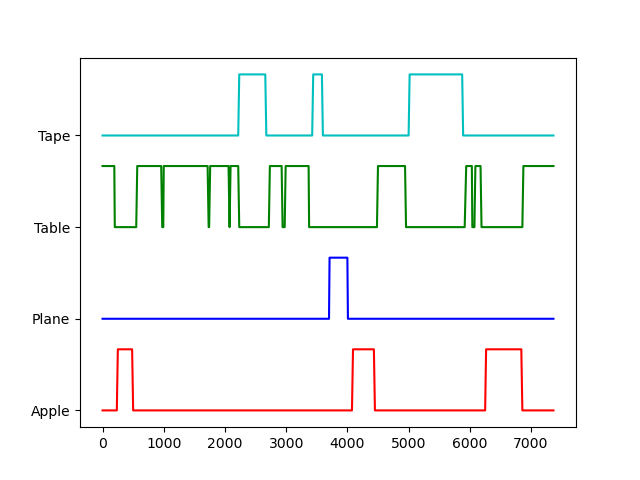

gc v = 70
alloeye_92r1_5_ret


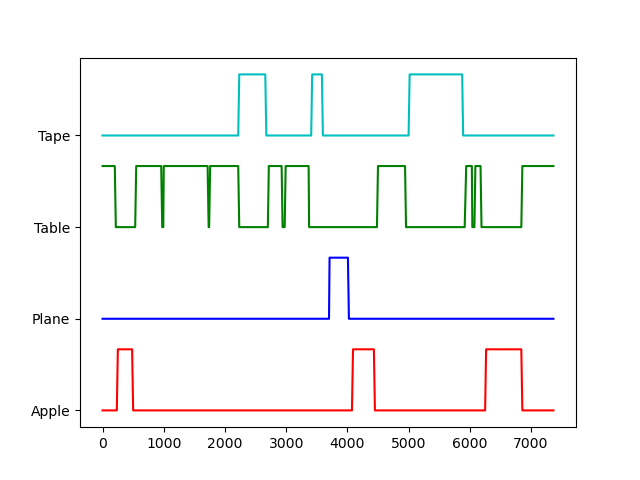

In [6]:
# v plots
ind = 1
# print(ind)
tps = fix_tps[ind].copy()

ax = plt.figure().add_subplot()
# calculate velocity
t = tps.eye_timestamp_ms.to_numpy()
# velocity (angular) - also in a function in FixationProcessor but need vectors and time_diff
point_matrix = TimepointProcessor.create_gaze_point_matrix(tps)
head_loc_mat = TimepointProcessor.create_head_loc_matrix(tps)
vectors = point_matrix - head_loc_mat
angles = []
for i in range(1, len(vectors)):
    angles.append(FixationProcessor.angle_between(vectors[i - 1], vectors[i]))
angles = np.array(angles)
time_diff = np.diff(t)
# velocity (angular)
v_ang = FixationProcessor.angular_velocity_vec(tps)
ax.plot(t[1:], v_ang)
for v in v_thresholds:
    ax.axhline(y=(v/1000), color='r')
max_v = np.max(v)/1000
ax.set_ybound([0, max_v + max_v*0.8])
plt.show()


for name, df in v_algos.items():
    print(name)
    
    
    # on off plots
    full_objects = np.unique(tps.gaze_object)
    # print(full_objects)
    for v in v_thresholds:
        for obj in full_objects:
            string = f'{name}_v{v}_fixation'
            tps[obj] = (tps.gaze_object == obj) & (tps[string] == 1)
        print(f"{name} v = {v}")
        on_off_plot(tps, full_objects)
        plt.show()




ivdt
ivdt d = 1.0
alloeye_92r1_5_ret


C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


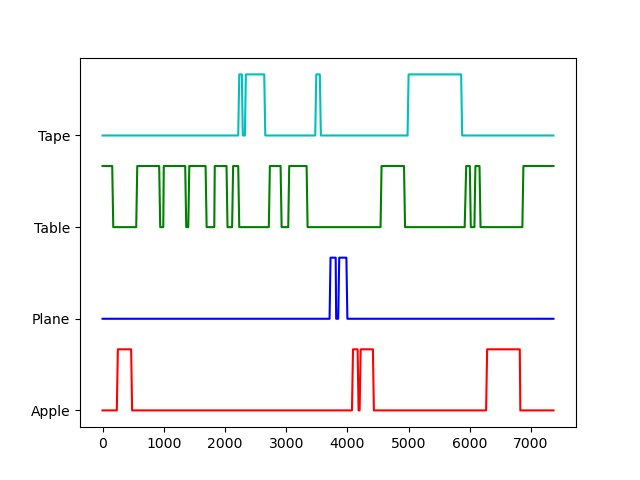

ivdt d = 2.0
alloeye_92r1_5_ret


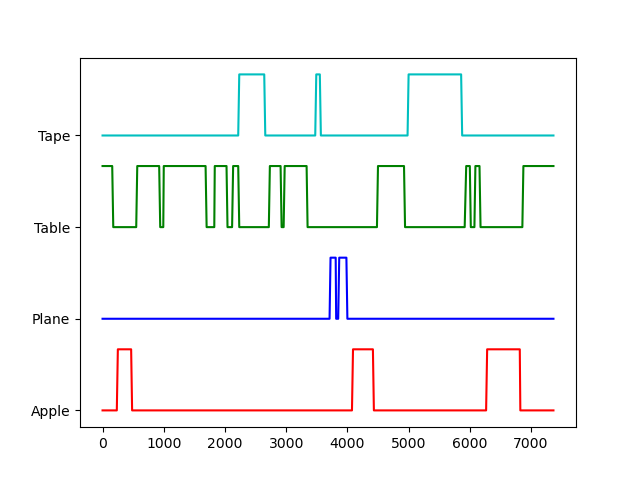

ivdt d = 3.0
alloeye_92r1_5_ret


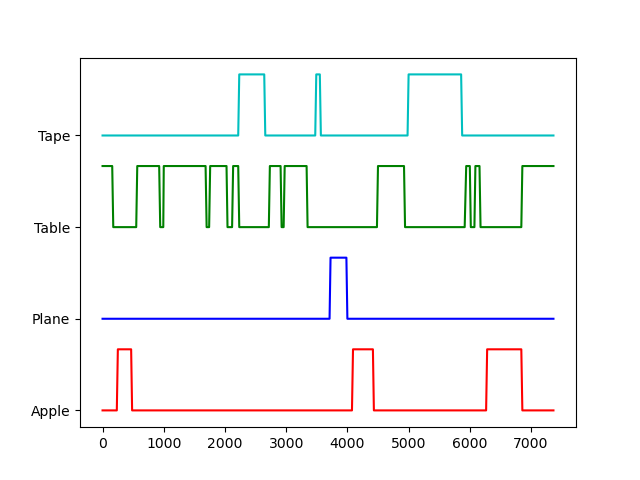

ivdt d = 4.0
alloeye_92r1_5_ret


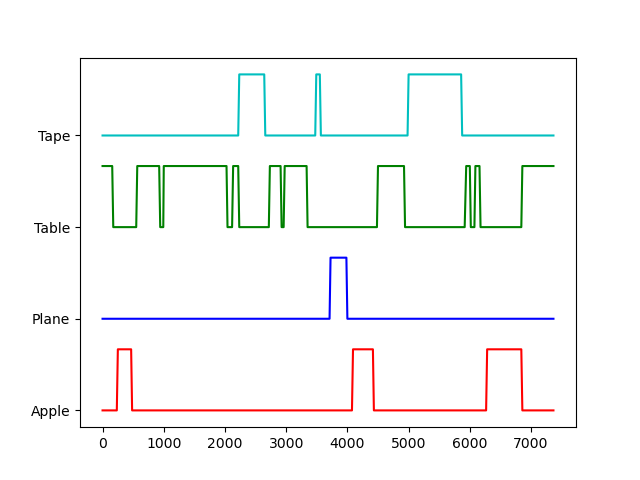

ivdt d = 5.0
alloeye_92r1_5_ret


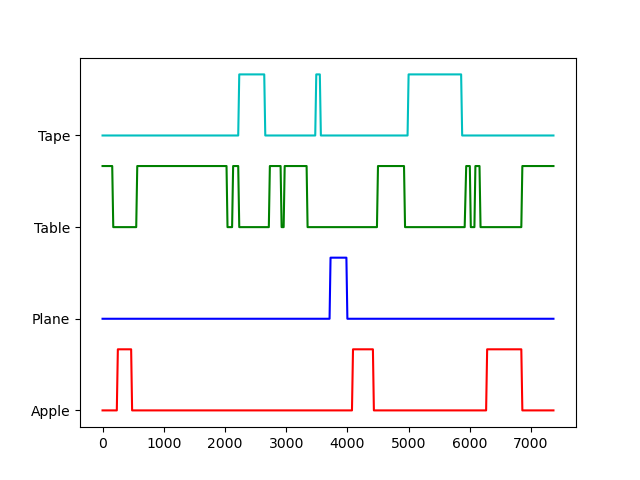

idt
idt d = 1.0
alloeye_92r1_5_ret


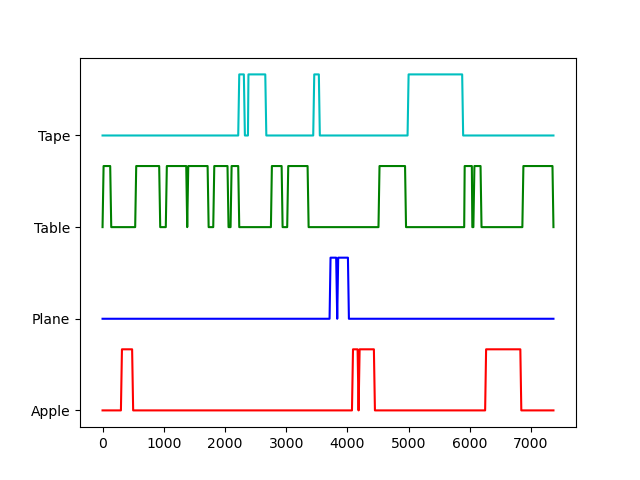

idt d = 2.0
alloeye_92r1_5_ret


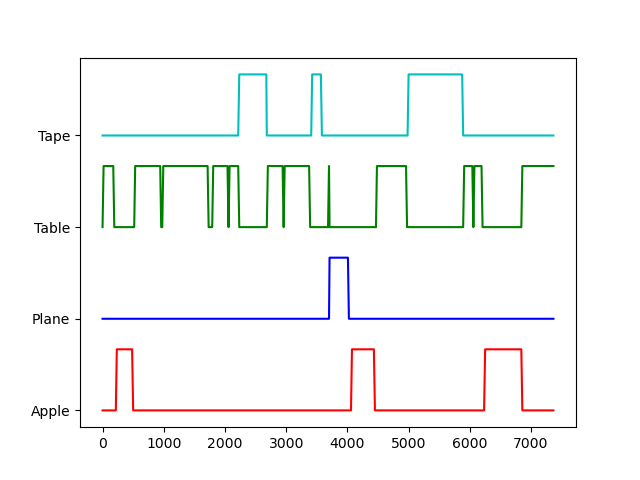

idt d = 3.0
alloeye_92r1_5_ret


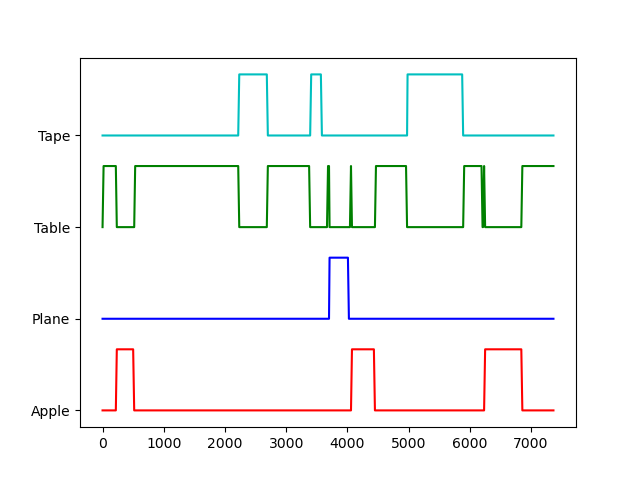

idt d = 4.0
alloeye_92r1_5_ret


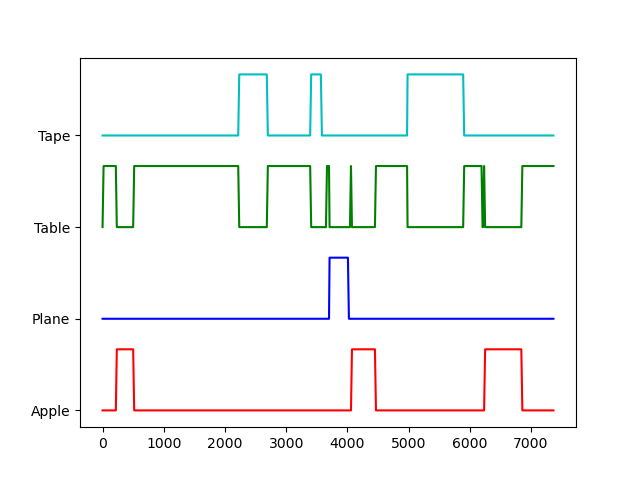

idt d = 5.0
alloeye_92r1_5_ret


C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\4163497770.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


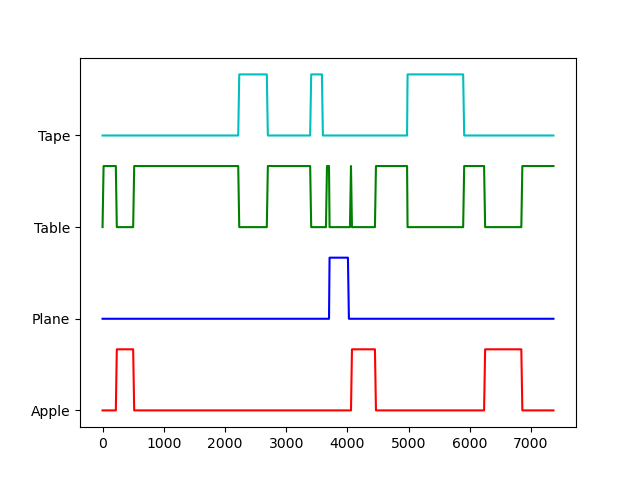

In [7]:
# d plots
ind = 1
# print(ind)
tps = fix_tps[ind].copy()


for name, df in d_algos.items():
    print(name)
    
    
    # on off plots
    full_objects = np.unique(tps.gaze_object)
    # print(full_objects)
    for d in d_thresholds:
        for obj in full_objects:
            string = f'{name}_d{d}_fixation'
            tps[obj] = (tps.gaze_object == obj) & (tps[string] == 1)
        print(f"{name} d = {d}")
        on_off_plot(tps, full_objects)
        plt.show()



In [8]:
# get viewings data


cols = ['n_fix_total', 'dwell_total', 'hn']
    
v_full_fix_dfs = {}
for name, dfs in v_fix_dfs.items():
    for v in v_thresholds:
        v_full_fix_dfs.update({name: v_fix_dfs[name][0]})
d_full_fix_dfs = {}
for name, dfs in d_fix_dfs.items():
    for d in d_thresholds:
        d_full_fix_dfs.update({name: d_fix_dfs[name][0]})

full_tp_df = fix_tps[0]
for i in range(1, len(viewings)):
    for name, dfs in v_fix_dfs.items():
        if dfs[i] is not None:
            v_full_fix_dfs[name] = pd.concat([v_full_fix_dfs[name], dfs[i]]).reset_index(drop=True)
    for name, dfs in d_fix_dfs.items():
        if dfs[i] is not None:
            d_full_fix_dfs[name] = pd.concat([d_full_fix_dfs[name], dfs[i]]).reset_index(drop=True)
        
    if fix_tps[i] is not None:
        full_tp_df = pd.concat([full_tp_df, fix_tps[i]]).reset_index(drop=True) 
        
view_df = fetch_viewings("all", viewing_list=viewings)
full_view_df = None
for name, dfs in v_fix_dfs.items():
    algo_name = algo_names[name.split('_')[0]]
    temp_df = to_viewing(view_df.copy(deep=True), v_full_fix_dfs[name], full_tp_df, fix_method=FixAlgo[algo_name], features=cols)
    temp_df['algorithm'] = np.repeat(f"V{name}", len(temp_df))
    full_view_df = temp_df if full_view_df is None else pd.concat([full_view_df, temp_df]).reset_index(drop=True)
    

- fetching viewings from db...
viewings fetched from db
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials
Features added to df for 38 of 38 trials


In [9]:
for name, dfs in d_fix_dfs.items():
    print(name)
    algo_name = algo_names[name.split('_')[0]]
    temp_df = to_viewing(view_df.copy(deep=True), d_full_fix_dfs[name], full_tp_df, fix_method=FixAlgo[algo_name], features=cols)
    temp_df['algorithm'] = np.repeat(f"D{name}", len(temp_df))
    full_view_df = temp_df if full_view_df is None else pd.concat([full_view_df, temp_df]).reset_index(drop=True)


for col in cols:
    full_view_df = full_view_df[np.invert(pd.isna(full_view_df[col]))].reset_index(drop=True)

ivdt_1.0
Features added to df for 38 of 38 trials
ivdt_2.0
Features added to df for 38 of 38 trials
ivdt_3.0
Features added to df for 38 of 38 trials
ivdt_4.0
Features added to df for 38 of 38 trials
ivdt_5.0
Features added to df for 38 of 38 trials
idt_1.0
Features added to df for 38 of 38 trials
idt_2.0
Features added to df for 38 of 38 trials
idt_3.0
Features added to df for 38 of 38 trials
idt_4.0
Features added to df for 38 of 38 trials
idt_5.0
Features added to df for 38 of 38 trials


In [10]:
algo_names

{'ivdt': 'I_VDT', 'gc': 'GazeCollision', 'idt': 'VR_IDT'}

In [11]:
display(full_view_df[full_view_df.n_fix_total > 100].style)

,viewing_id,ppt_id,study_id,block_id,trial_id,viewing_type,co_x_raw,co_z_raw,co_x_rot_adj,co_z_rot_adj,obj1_name,obj1_x,obj1_z,obj2_name,obj2_x,obj2_z,obj3_name,obj3_x,obj3_z,obj4_name,obj4_x,obj4_z,obj5_name,obj5_x,obj5_z,test_1,hn,hd,n_sacc_total,n_sacc_obj1,n_sacc_obj2,n_sacc_obj3,n_sacc_obj4,n_sacc_table,velocity_mean_total,velocity_std_total,n_fix_total,n_fix_obj1,n_fix_obj2,n_fix_obj3,n_fix_obj4,n_fix_table,n_fix_other,dwell_total,dwell_obj1,dwell_obj2,dwell_obj3,dwell_obj4,dwell_table,dwell_other,t_first_array,t_first_obj1,t_first_obj2,t_first_obj3,t_first_obj4,pupil_diam_centre,pupil_diam_spread,p_matrix,p_matrix_objects,n_fix_pp,dwell_pp,dispersion_mean,drop_out_total,n_blinks,dur_blinks,p_trackloss,ht,algorithm


In [12]:
print(full_view_df.shape)
display(full_view_df[full_view_df.dwell_total <= 10].style)

(760, 68)


,viewing_id,ppt_id,study_id,block_id,trial_id,viewing_type,co_x_raw,co_z_raw,co_x_rot_adj,co_z_rot_adj,obj1_name,obj1_x,obj1_z,obj2_name,obj2_x,obj2_z,obj3_name,obj3_x,obj3_z,obj4_name,obj4_x,obj4_z,obj5_name,obj5_x,obj5_z,test_1,hn,hd,n_sacc_total,n_sacc_obj1,n_sacc_obj2,n_sacc_obj3,n_sacc_obj4,n_sacc_table,velocity_mean_total,velocity_std_total,n_fix_total,n_fix_obj1,n_fix_obj2,n_fix_obj3,n_fix_obj4,n_fix_table,n_fix_other,dwell_total,dwell_obj1,dwell_obj2,dwell_obj3,dwell_obj4,dwell_table,dwell_other,t_first_array,t_first_obj1,t_first_obj2,t_first_obj3,t_first_obj4,pupil_diam_centre,pupil_diam_spread,p_matrix,p_matrix_objects,n_fix_pp,dwell_pp,dispersion_mean,drop_out_total,n_blinks,dur_blinks,p_trackloss,ht,algorithm


In [13]:
full_view_df = full_view_df[full_view_df.n_fix_total != 999]
full_view_df = full_view_df[full_view_df.dwell_total != 999]
full_view_df = full_view_df[full_view_df.dwell_total != -999]

In [14]:
def subboxplots_thresholds(df, cols, V_or_D, n_cols=4, colors=["r", "b", "g", "c", "m"]):
    df = df[df.algorithm.str.startswith(V_or_D)]
    df[['algo', 'threshold']] = df['algorithm'].str.split('_', expand=True)
    df.threshold = pd.to_numeric(df.threshold)
    algos = np.unique(df.algo)
    xlabs = np.unique(df.threshold)
    print(algos)
    print(xlabs)

    n_cols = n_cols
    n_rows = int(np.ceil(len(cols)/n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5), dpi=100)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.6,
                        top=0.9,
                        wspace=0.6,
                        hspace=0.6)
    # ticks = list(replace_map.values())
    # labels = list(replace_map.keys())
    # colors = itertools.cycle()
    for i in range(len(cols)):
        row = int(np.floor(i/n_cols))
        col = i % n_cols
        feat = cols[i]
        lines = []
        for j in range(len(algos)):
            algo = algos[j]
            temp_df = df[df.algo == algo]
            c = colors[j]
            if n_rows > 1:
                ax = axes[row, col]
            else:
                ax = axes[col]
            plt.sca(ax)
            temp_df.groupby(by=['threshold']).boxplot(column=feat, subplots=False, boxprops=dict(color=c), medianprops=dict(color=c, linewidth=1), whiskerprops=dict(color=c))
            # create a custom legend based on line colors
            algo_name = algo.split(V_or_D)[1]
            line = plt.Line2D([], [], color=c, label=algo_name)
            lines.append(line)

            # axes[row, col].set_xticks(ticks)
        legend = ax.legend(handles=lines)
        ax.set_xticks(range(len(xlabs)+1))
        ax.set_xticklabels(["", *xlabs])
        ax.set_title(feat)
        ax.grid(None)


In [15]:
np.unique(full_view_df.algorithm)

array(['Didt_1.0', 'Didt_2.0', 'Didt_3.0', 'Didt_4.0', 'Didt_5.0',
       'Divdt_1.0', 'Divdt_2.0', 'Divdt_3.0', 'Divdt_4.0', 'Divdt_5.0',
       'Vgc_30', 'Vgc_40', 'Vgc_50', 'Vgc_60', 'Vgc_70', 'Vivdt_30',
       'Vivdt_40', 'Vivdt_50', 'Vivdt_60', 'Vivdt_70'], dtype=object)

C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['algo', 'threshold']] = df['algorithm'].str.split('_', expand=True)
C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['algo', 'threshold']] = df['algorithm'].str.split('_', expand=True)
C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

['Vgc' 'Vivdt']
[30 40 50 60 70]
['Didt' 'Divdt']
[1. 2. 3. 4. 5.]


C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['algo', 'threshold']] = df['algorithm'].str.split('_', expand=True)
C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['algo', 'threshold']] = df['algorithm'].str.split('_', expand=True)
C:\Users\Luke\AppData\Local\Temp\ipykernel_21416\698409821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

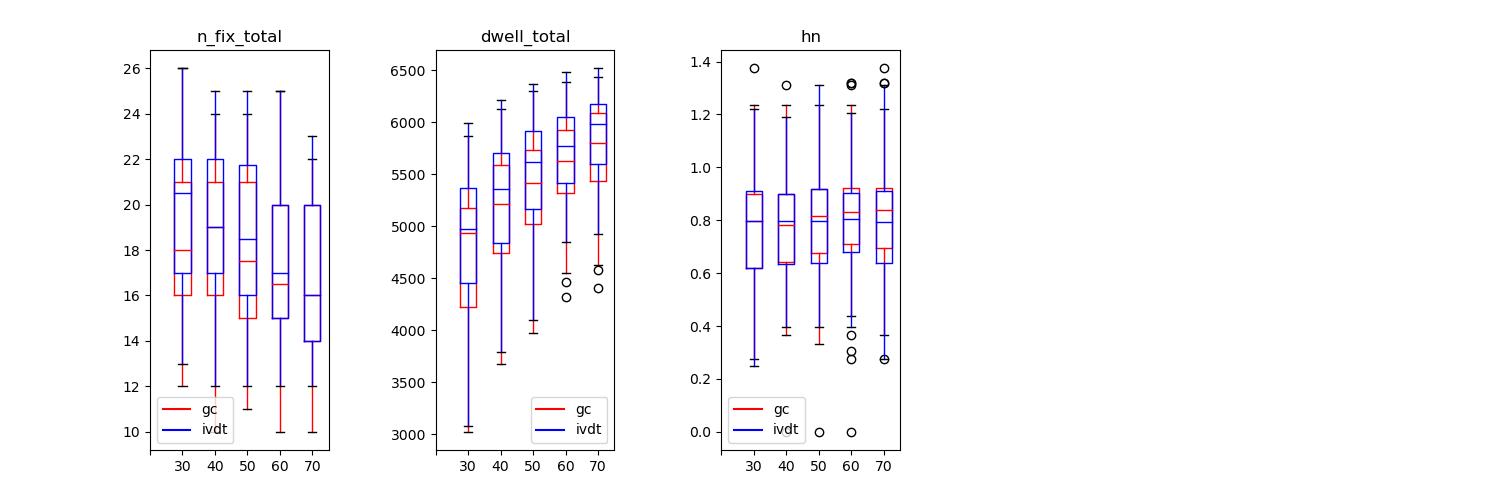

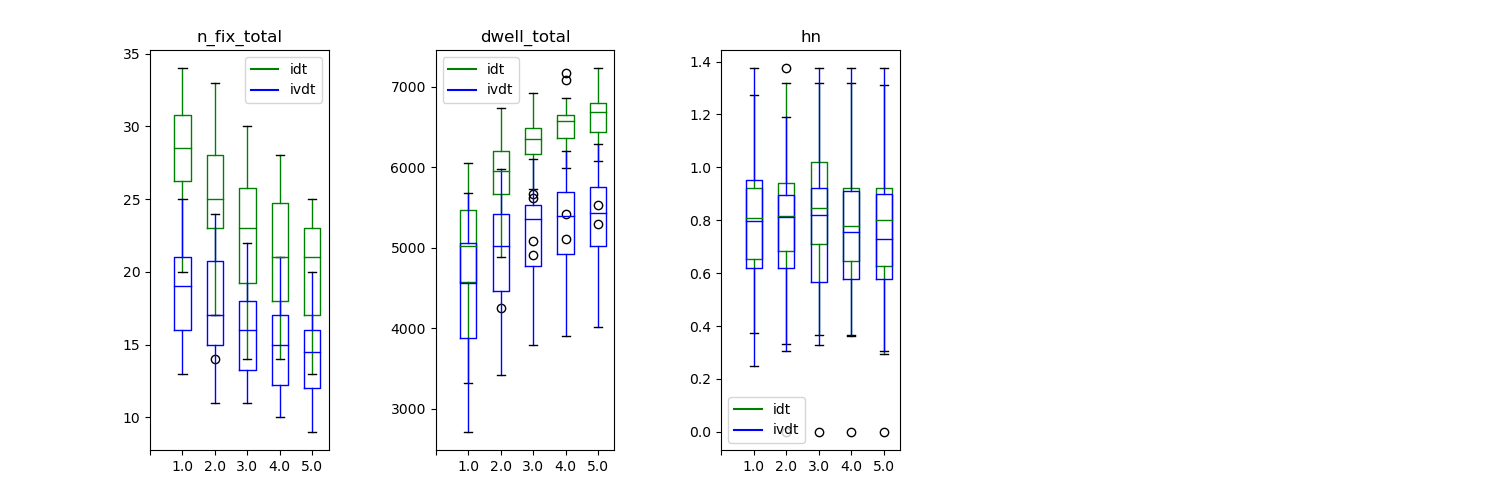

In [16]:
cols = ['n_fix_total', 'dwell_total', 'hn']
subboxplots_thresholds(full_view_df, cols, 'V', n_cols=3, colors=['r', 'b'])
subboxplots_thresholds(full_view_df, cols, 'D', n_cols=3, colors=['g', 'b'])